In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.chdir('..')

import pickle
import re
from pathlib import Path

import torch
import datasets
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from transformers.modeling_outputs import CausalLMOutputWithPast

from tqdm import tqdm

from model import MemoryCell

In [2]:
pd.set_option('display.max_rows', 200)

In [ ]:
import pandas as pd
texts_df = pd.read_csv('./data/pg19_valid_1k_chunks.csv', index_col=0)
texts_df.head()

,text
0,"'Let us stay here,' she exclaimed. 'The one ro..."
1,These lobsters don't realize that Jonesy's fas...
2,It certainly was not relief that he felt on di...
3,Down to 1765 the duty imposed was only one pen...
4,"And what was, perhaps, more extraordinary, tho..."


In [5]:
import json
tokens_to_bytes = json.load(open('./data/tokens_to_bytes.json', 'r'))

In [6]:
models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
          'EleutherAI/pythia-2.8b',
          'allenai/OLMo-1B-0724-hf',
          'princeton-nlp/Sheared-LLaMA-1.3B',
          'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B']
N_mem_tokens = 1

data = []
from pathlib import Path
for model_name in tqdm(models):
    cfg = AutoConfig.from_pretrained(model_name)
    getattr(cfg, 'num_hidden_layers')
    load_path = Path(f'./runs/{model_name}/')
    for file_path in load_path.glob(f'mem_{N_mem_tokens}_len_*.pkl'):
        if file_path.is_file():
            # Extract max_length from the file name using regex
            match = re.search(f'mem_{N_mem_tokens}_len_(\d+)(_rnd_vocab_100k)?\.pkl', file_path.name)
            if match:
                max_length = int(match.group(1))
            else:
                continue
            
            try:
                with open(file_path, 'rb') as f:
                    d = pickle.load(f)
            except Exception as e:
                continue

        try:
            d = pickle.load(open(file_path, 'rb'))
        except:
            continue
        for el in d:
            data += [{
                'model_name': model_name,
                'max_length': el['max_length'],
                'n_mem_tokens': el['n_mem_tokens'],
                'original_loss': el['original_loss'],
                'best_loss': np.min(el['losses'][:5000]),#el['best_loss'],
                'best_accuracy': np.max(el['accuracies'][:5000]),#el['best_accuracy'],#np.max(el['accuracies'][:5000]), #
                'shuffled': el['args'].get('shuffled', False),
                'mem_dim': el['best_memory_params'].shape[-1],
                'n_layers': getattr(cfg, 'num_hidden_layers'),
                'vocab_size': getattr(cfg, 'vocab_size'),
                'n_att_heads': getattr(cfg, 'num_attention_heads'),
                'intermediate_size': getattr(cfg, 'intermediate_size'),
                'token2bytes': tokens_to_bytes.get(model_name)
            }]
all_models_df = pd.DataFrame(data)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:22<00:00,  2.45s/it]


In [7]:
n_mem_tokens = 1
all_models_rnd_df = all_models_df[(all_models_df['shuffled'] == True)&(all_models_df['n_mem_tokens'] == n_mem_tokens)]
all_models_rnd_df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads,intermediate_size,token2bytes
550,EleutherAI/pythia-160m,215,1,7.226313,4.584621,0.406542,True,768,12,50304,12,3072,0.231407
551,EleutherAI/pythia-160m,145,1,6.809530,3.224154,0.513889,True,768,12,50304,12,3072,0.231407
552,EleutherAI/pythia-160m,159,1,7.027385,3.458629,0.556962,True,768,12,50304,12,3072,0.231407
553,EleutherAI/pythia-160m,204,1,7.280647,4.640838,0.349754,True,768,12,50304,12,3072,0.231407
554,EleutherAI/pythia-160m,33,1,7.539730,0.156503,1.000000,True,768,12,50304,12,3072,0.231407
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,meta-llama/Meta-Llama-3.1-8B,792,1,5.921691,0.203639,0.992415,True,4096,32,128256,32,14336,0.229209
5946,meta-llama/Meta-Llama-3.1-8B,259,1,5.959318,0.012301,1.000000,True,4096,32,128256,32,14336,0.229209
5947,meta-llama/Meta-Llama-3.1-8B,528,1,6.088220,0.353147,0.960152,True,4096,32,128256,32,14336,0.229209
5948,meta-llama/Meta-Llama-3.1-8B,589,1,5.844290,0.042890,0.998299,True,4096,32,128256,32,14336,0.229209


In [8]:
df = all_models_rnd_df[['model_name', 'max_length', 'best_accuracy']]
df

,model_name,max_length,best_accuracy
550,EleutherAI/pythia-160m,215,0.406542
551,EleutherAI/pythia-160m,145,0.513889
552,EleutherAI/pythia-160m,159,0.556962
553,EleutherAI/pythia-160m,204,0.349754
554,EleutherAI/pythia-160m,33,1.000000
...,...,...,...
5945,meta-llama/Meta-Llama-3.1-8B,792,0.992415
5946,meta-llama/Meta-Llama-3.1-8B,259,1.000000
5947,meta-llama/Meta-Llama-3.1-8B,528,0.960152
5948,meta-llama/Meta-Llama-3.1-8B,589,0.998299


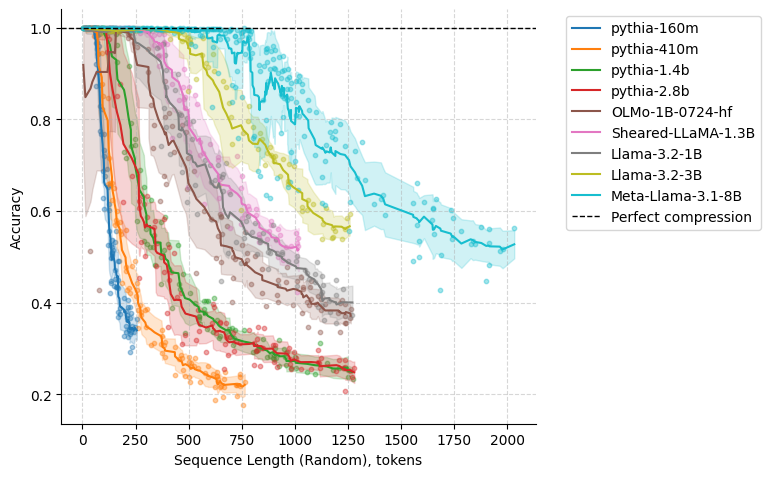

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# We assume df has columns ['model_name', 'max_length', 'best_accuracy']
# Each row is one data point.

unique_models = df['model_name'].unique()

# Optional color palette
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_models)))

fig, ax = plt.subplots(figsize=(8, 5))

# Rolling window "radius" - e.g., 5 means we look at 5 points before and 5 points after
window_radius = 5
window_size = 2 * window_radius + 1

for i, model in enumerate(unique_models):
    # Filter data for one model
    sub = df[df['model_name'] == model].copy()
    # Sort by x
    sub = sub.sort_values('max_length')
    
    # If you also want to see the original data:
    ax.scatter(
        sub['max_length'],
        sub['best_accuracy'],
        color=colors[i],
        alpha=0.4,
        s=10,
    )
    
    # Rolling calculations: mean and std
    # By default, rolling() uses consecutive rows. Because we've sorted by x,
    # each row is a consecutive x-value in ascending order.
    sub['rolling_mean'] = (
        sub['best_accuracy']
        .rolling(window=window_size, center=True, min_periods=1)
        .mean()
    )
    sub['rolling_std'] = (
        sub['best_accuracy']
        .rolling(window=window_size, center=True, min_periods=1)
        .std()
    )
    
    # Plot the smoothed line (rolling mean)
    ax.plot(
        sub['max_length'],
        sub['rolling_mean'],
        color=colors[i],
        linewidth=1.5,
        label=model.split('/', 1)[-1]  # shortened label
    )
    
    # Compute the corridor boundaries
    y_lower = sub['rolling_mean'] - sub['rolling_std']
    y_upper = sub['rolling_mean'] + sub['rolling_std']
    y_upper = np.clip(y_upper, 0.0, 1.0)
    
    # Fill between lower & upper corridor
    ax.fill_between(
        sub['max_length'],
        y_lower, 
        y_upper,
        color=colors[i],
        alpha=0.2
    )

ax.axhline(y=1.0, color='black', linestyle='--', linewidth=1, label='Perfect compression')

ax.set_xlabel("Sequence Length (Random), tokens")
ax.set_ylabel("Accuracy")

# If your lengths cover several orders of magnitude, log-scale helps spread points
# ax.set_xscale('log')
# ax.set_ylim((0.4, 1.01))

# Place the legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove top/right spines, add a dashed grid
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="both", which="major", linestyle="--", alpha=0.5)

import matplotlib as mpl
mpl.rcParams['font.size'] = 14           # Base font size
mpl.rcParams['axes.labelsize'] = 14      # Axis label font size
mpl.rcParams['axes.titlesize'] = 14      # Title font size
mpl.rcParams['xtick.labelsize'] = 12     # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 12     # Y-axis tick label font size
mpl.rcParams['legend.fontsize'] = 12     # Legend font size

plt.tight_layout()
plt.show()
